<a href="https://colab.research.google.com/github/ameranismail/Deep_learning_TPS/blob/main/transfer_learning_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning & fine-tuning


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


## An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

To solidify these concepts, let's walk you through a concrete end-to-end transfer
learning & fine-tuning example. We will load the Xception model, pre-trained on
 ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.

### Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset,
you'll probably want to use the utility
`tf.keras.preprocessing.image_dataset_from_directory` to generate similar labeled
 dataset objects from a set of images on disk filed into class-specific folders.

Transfer learning is most useful when working with very small datasets. To keep our
dataset small, we will use 40% of the original training data (25,000 images) for
 training, 10% for validation, and 10% for testing.

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
                                             as_supervised=True)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.

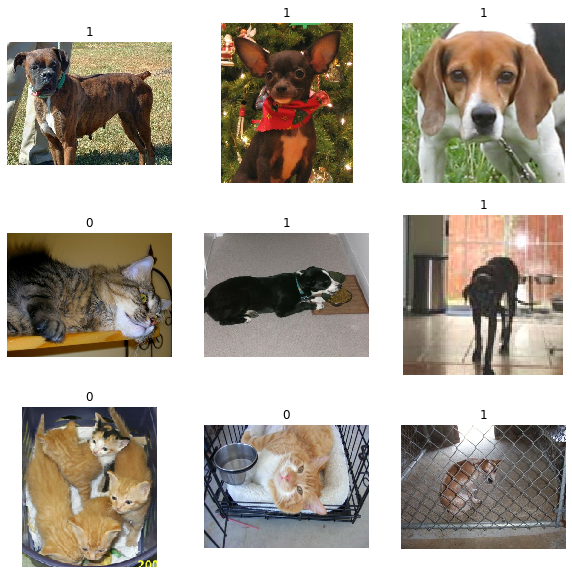

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

We can also see that label 1 is "dog" and label 0 is "cat".

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
 neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
 part of the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This gets very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
 of the model, when we create it.

Let's resize images to 150x150:

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
 introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import *
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Using TensorFlow backend.


Let's visualize what the first image of the first batch looks like after various random
 transformations:

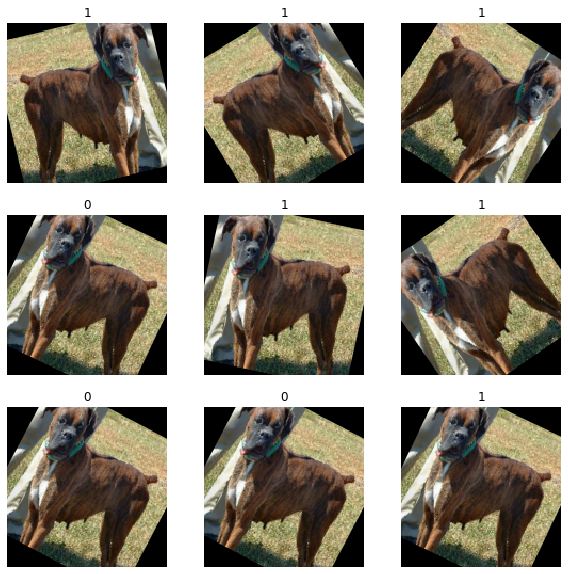

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

## Train the top layer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10


157/291 [===============>..............] - ETA: 0s - loss: 0.1240 - binary_accuracy: 0.906 - ETA: 23:29 - loss: 0.1061 - binary_accuracy: 0.92 - ETA: 31:04 - loss: 0.0978 - binary_accuracy: 0.94 - ETA: 34:37 - loss: 0.1022 - binary_accuracy: 0.95 - ETA: 36:53 - loss: 0.1131 - binary_accuracy: 0.95 - ETA: 38:02 - loss: 0.1580 - binary_accuracy: 0.93 - ETA: 38:47 - loss: 0.1506 - binary_accuracy: 0.93 - ETA: 39:43 - loss: 0.1611 - binary_accuracy: 0.93 - ETA: 40:07 - loss: 0.1762 - binary_accuracy: 0.93 - ETA: 40:13 - loss: 0.1656 - binary_accuracy: 0.93 - ETA: 40:15 - loss: 0.1623 - binary_accuracy: 0.93 - ETA: 40:30 - loss: 0.1522 - binary_accuracy: 0.94 - ETA: 40:35 - loss: 0.1520 - binary_accuracy: 0.94 - ETA: 40:45 - loss: 0.1479 - binary_accuracy: 0.94 - ETA: 40:52 - loss: 0.1471 - binary_accuracy: 0.94 - ETA: 40:59 - loss: 0.1434 - binary_accuracy: 0.94 - ETA: 41:15 - loss: 0.1381 - binary_accuracy: 0.95 - ETA: 41:45 - loss: 0.1347 - binary_accuracy: 0.95 - ETA: 41:39 - loss: 0.13

291/291 [==============================] - ETA: 21:32 - loss: 0.1344 - binary_accuracy: 0.94 - ETA: 21:25 - loss: 0.1349 - binary_accuracy: 0.94 - ETA: 21:19 - loss: 0.1370 - binary_accuracy: 0.94 - ETA: 21:12 - loss: 0.1365 - binary_accuracy: 0.94 - ETA: 21:08 - loss: 0.1362 - binary_accuracy: 0.94 - ETA: 21:02 - loss: 0.1358 - binary_accuracy: 0.94 - ETA: 20:55 - loss: 0.1352 - binary_accuracy: 0.94 - ETA: 20:48 - loss: 0.1358 - binary_accuracy: 0.94 - ETA: 20:41 - loss: 0.1359 - binary_accuracy: 0.94 - ETA: 20:34 - loss: 0.1355 - binary_accuracy: 0.94 - ETA: 20:27 - loss: 0.1348 - binary_accuracy: 0.94 - ETA: 20:20 - loss: 0.1344 - binary_accuracy: 0.94 - ETA: 20:13 - loss: 0.1339 - binary_accuracy: 0.94 - ETA: 20:06 - loss: 0.1338 - binary_accuracy: 0.94 - ETA: 19:59 - loss: 0.1341 - binary_accuracy: 0.94 - ETA: 19:52 - loss: 0.1341 - binary_accuracy: 0.94 - ETA: 19:45 - loss: 0.1341 - binary_accuracy: 0.94 - ETA: 19:37 - loss: 0.1341 - binary_accuracy: 0.94 - ETA: 19:29 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.2369 - binary_accuracy: 0.875 - ETA: 22:13 - loss: 0.2216 - binary_accuracy: 0.89 - ETA: 30:23 - loss: 0.1636 - binary_accuracy: 0.92 - ETA: 33:55 - loss: 0.1342 - binary_accuracy: 0.94 - ETA: 36:56 - loss: 0.1144 - binary_accuracy: 0.95 - ETA: 38:00 - loss: 0.1193 - binary_accuracy: 0.95 - ETA: 38:47 - loss: 0.1214 - binary_accuracy: 0.95 - ETA: 39:17 - loss: 0.1324 - binary_accuracy: 0.94 - ETA: 39:46 - loss: 0.1381 - binary_accuracy: 0.94 - ETA: 40:11 - loss: 0.1327 - binary_accuracy: 0.94 - ETA: 40:20 - loss: 0.1266 - binary_accuracy: 0.94 - ETA: 40:24 - loss: 0.1200 - binary_accuracy: 0.95 - ETA: 40:27 - loss: 0.1191 - binary_accuracy: 0.95 - ETA: 40:32 - loss: 0.1191 - binary_accuracy: 0.94 - ETA: 40:35 - loss: 0.1231 - binary_accuracy: 0.94 - ETA: 40:39 - loss: 0.1175 - binary_accuracy: 0.94 - ETA: 40:42 - loss: 0.1153 - binary_accuracy: 0.94 - ETA: 40:39 - loss: 0.1142 - binary_accuracy: 0.94 - ETA: 40:36 - loss: 0.11

291/291 [==============================] - ETA: 22:59 - loss: 0.1270 - binary_accuracy: 0.94 - ETA: 22:49 - loss: 0.1269 - binary_accuracy: 0.94 - ETA: 22:40 - loss: 0.1280 - binary_accuracy: 0.94 - ETA: 22:31 - loss: 0.1281 - binary_accuracy: 0.94 - ETA: 22:21 - loss: 0.1277 - binary_accuracy: 0.94 - ETA: 22:12 - loss: 0.1273 - binary_accuracy: 0.94 - ETA: 22:03 - loss: 0.1280 - binary_accuracy: 0.94 - ETA: 21:53 - loss: 0.1282 - binary_accuracy: 0.94 - ETA: 21:44 - loss: 0.1280 - binary_accuracy: 0.94 - ETA: 21:34 - loss: 0.1278 - binary_accuracy: 0.94 - ETA: 21:24 - loss: 0.1275 - binary_accuracy: 0.94 - ETA: 21:13 - loss: 0.1269 - binary_accuracy: 0.94 - ETA: 21:02 - loss: 0.1266 - binary_accuracy: 0.94 - ETA: 20:51 - loss: 0.1267 - binary_accuracy: 0.94 - ETA: 20:41 - loss: 0.1267 - binary_accuracy: 0.94 - ETA: 20:30 - loss: 0.1261 - binary_accuracy: 0.94 - ETA: 20:20 - loss: 0.1258 - binary_accuracy: 0.94 - ETA: 20:09 - loss: 0.1273 - binary_accuracy: 0.94 - ETA: 19:58 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.0640 - binary_accuracy: 1.000 - ETA: 21:56 - loss: 0.1087 - binary_accuracy: 0.96 - ETA: 29:15 - loss: 0.0925 - binary_accuracy: 0.96 - ETA: 32:44 - loss: 0.1032 - binary_accuracy: 0.96 - ETA: 34:48 - loss: 0.1369 - binary_accuracy: 0.94 - ETA: 36:29 - loss: 0.1431 - binary_accuracy: 0.94 - ETA: 37:22 - loss: 0.1417 - binary_accuracy: 0.94 - ETA: 37:54 - loss: 0.1527 - binary_accuracy: 0.93 - ETA: 38:22 - loss: 0.1573 - binary_accuracy: 0.93 - ETA: 38:40 - loss: 0.1508 - binary_accuracy: 0.93 - ETA: 38:56 - loss: 0.1616 - binary_accuracy: 0.92 - ETA: 39:09 - loss: 0.1546 - binary_accuracy: 0.92 - ETA: 39:22 - loss: 0.1598 - binary_accuracy: 0.92 - ETA: 39:29 - loss: 0.1636 - binary_accuracy: 0.92 - ETA: 39:40 - loss: 0.1589 - binary_accuracy: 0.92 - ETA: 40:03 - loss: 0.1578 - binary_accuracy: 0.92 - ETA: 40:09 - loss: 0.1497 - binary_accuracy: 0.93 - ETA: 40:10 - loss: 0.1494 - binary_accuracy: 0.92 - ETA: 40:08 - loss: 0.14

291/291 [==============================] - ETA: 23:48 - loss: 0.1248 - binary_accuracy: 0.94 - ETA: 23:37 - loss: 0.1252 - binary_accuracy: 0.94 - ETA: 23:25 - loss: 0.1259 - binary_accuracy: 0.94 - ETA: 23:14 - loss: 0.1260 - binary_accuracy: 0.94 - ETA: 23:02 - loss: 0.1256 - binary_accuracy: 0.94 - ETA: 22:51 - loss: 0.1251 - binary_accuracy: 0.94 - ETA: 22:40 - loss: 0.1252 - binary_accuracy: 0.94 - ETA: 22:30 - loss: 0.1250 - binary_accuracy: 0.94 - ETA: 22:20 - loss: 0.1253 - binary_accuracy: 0.94 - ETA: 22:09 - loss: 0.1250 - binary_accuracy: 0.94 - ETA: 21:57 - loss: 0.1247 - binary_accuracy: 0.94 - ETA: 21:45 - loss: 0.1248 - binary_accuracy: 0.94 - ETA: 21:34 - loss: 0.1242 - binary_accuracy: 0.94 - ETA: 21:22 - loss: 0.1249 - binary_accuracy: 0.94 - ETA: 21:11 - loss: 0.1245 - binary_accuracy: 0.94 - ETA: 20:59 - loss: 0.1244 - binary_accuracy: 0.94 - ETA: 20:48 - loss: 0.1242 - binary_accuracy: 0.94 - ETA: 20:37 - loss: 0.1248 - binary_accuracy: 0.94 - ETA: 20:26 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.937 - ETA: 22:33 - loss: 0.1072 - binary_accuracy: 0.93 - ETA: 29:44 - loss: 0.1374 - binary_accuracy: 0.93 - ETA: 33:13 - loss: 0.1154 - binary_accuracy: 0.95 - ETA: 35:15 - loss: 0.1215 - binary_accuracy: 0.95 - ETA: 36:36 - loss: 0.1345 - binary_accuracy: 0.94 - ETA: 38:10 - loss: 0.1210 - binary_accuracy: 0.95 - ETA: 39:08 - loss: 0.1289 - binary_accuracy: 0.95 - ETA: 39:45 - loss: 0.1317 - binary_accuracy: 0.94 - ETA: 40:04 - loss: 0.1348 - binary_accuracy: 0.94 - ETA: 40:27 - loss: 0.1364 - binary_accuracy: 0.94 - ETA: 40:36 - loss: 0.1316 - binary_accuracy: 0.94 - ETA: 40:42 - loss: 0.1352 - binary_accuracy: 0.94 - ETA: 40:58 - loss: 0.1298 - binary_accuracy: 0.94 - ETA: 41:00 - loss: 0.1372 - binary_accuracy: 0.93 - ETA: 40:58 - loss: 0.1324 - binary_accuracy: 0.93 - ETA: 40:54 - loss: 0.1325 - binary_accuracy: 0.93 - ETA: 40:52 - loss: 0.1288 - binary_accuracy: 0.93 - ETA: 40:53 - loss: 0.12

291/291 [==============================] - ETA: 21:23 - loss: 0.1237 - binary_accuracy: 0.94 - ETA: 21:14 - loss: 0.1240 - binary_accuracy: 0.94 - ETA: 21:05 - loss: 0.1258 - binary_accuracy: 0.94 - ETA: 20:56 - loss: 0.1256 - binary_accuracy: 0.94 - ETA: 20:47 - loss: 0.1251 - binary_accuracy: 0.94 - ETA: 20:39 - loss: 0.1248 - binary_accuracy: 0.94 - ETA: 20:29 - loss: 0.1242 - binary_accuracy: 0.94 - ETA: 20:20 - loss: 0.1248 - binary_accuracy: 0.94 - ETA: 20:10 - loss: 0.1246 - binary_accuracy: 0.94 - ETA: 20:00 - loss: 0.1241 - binary_accuracy: 0.94 - ETA: 19:50 - loss: 0.1240 - binary_accuracy: 0.94 - ETA: 19:41 - loss: 0.1236 - binary_accuracy: 0.94 - ETA: 19:31 - loss: 0.1237 - binary_accuracy: 0.94 - ETA: 19:21 - loss: 0.1238 - binary_accuracy: 0.94 - ETA: 19:12 - loss: 0.1239 - binary_accuracy: 0.94 - ETA: 19:02 - loss: 0.1233 - binary_accuracy: 0.94 - ETA: 18:52 - loss: 0.1234 - binary_accuracy: 0.94 - ETA: 18:43 - loss: 0.1235 - binary_accuracy: 0.94 - ETA: 18:33 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.906 - ETA: 33:38 - loss: 0.1746 - binary_accuracy: 0.89 - ETA: 44:07 - loss: 0.1677 - binary_accuracy: 0.90 - ETA: 50:32 - loss: 0.1580 - binary_accuracy: 0.91 - ETA: 52:45 - loss: 0.1731 - binary_accuracy: 0.92 - ETA: 54:43 - loss: 0.1650 - binary_accuracy: 0.93 - ETA: 55:06 - loss: 0.1514 - binary_accuracy: 0.94 - ETA: 55:41 - loss: 0.1516 - binary_accuracy: 0.94 - ETA: 54:52 - loss: 0.1558 - binary_accuracy: 0.93 - ETA: 56:09 - loss: 0.1540 - binary_accuracy: 0.93 - ETA: 55:35 - loss: 0.1513 - binary_accuracy: 0.93 - ETA: 55:03 - loss: 0.1510 - binary_accuracy: 0.93 - ETA: 54:12 - loss: 0.1523 - binary_accuracy: 0.93 - ETA: 53:32 - loss: 0.1495 - binary_accuracy: 0.93 - ETA: 52:46 - loss: 0.1579 - binary_accuracy: 0.93 - ETA: 52:16 - loss: 0.1558 - binary_accuracy: 0.92 - ETA: 51:49 - loss: 0.1495 - binary_accuracy: 0.93 - ETA: 51:34 - loss: 0.1441 - binary_accuracy: 0.93 - ETA: 51:08 - loss: 0.13

291/291 [==============================] - ETA: 28:51 - loss: 0.1379 - binary_accuracy: 0.94 - ETA: 28:35 - loss: 0.1376 - binary_accuracy: 0.94 - ETA: 28:20 - loss: 0.1383 - binary_accuracy: 0.94 - ETA: 28:04 - loss: 0.1384 - binary_accuracy: 0.94 - ETA: 27:48 - loss: 0.1379 - binary_accuracy: 0.94 - ETA: 27:32 - loss: 0.1375 - binary_accuracy: 0.94 - ETA: 27:17 - loss: 0.1374 - binary_accuracy: 0.94 - ETA: 27:01 - loss: 0.1377 - binary_accuracy: 0.94 - ETA: 26:45 - loss: 0.1377 - binary_accuracy: 0.94 - ETA: 26:30 - loss: 0.1376 - binary_accuracy: 0.94 - ETA: 26:15 - loss: 0.1374 - binary_accuracy: 0.94 - ETA: 25:59 - loss: 0.1371 - binary_accuracy: 0.94 - ETA: 25:44 - loss: 0.1366 - binary_accuracy: 0.94 - ETA: 25:29 - loss: 0.1370 - binary_accuracy: 0.94 - ETA: 25:14 - loss: 0.1373 - binary_accuracy: 0.94 - ETA: 24:59 - loss: 0.1368 - binary_accuracy: 0.94 - ETA: 24:44 - loss: 0.1364 - binary_accuracy: 0.94 - ETA: 24:29 - loss: 0.1364 - binary_accuracy: 0.94 - ETA: 24:15 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.1625 - binary_accuracy: 0.875 - ETA: 24:22 - loss: 0.2037 - binary_accuracy: 0.89 - ETA: 32:36 - loss: 0.1845 - binary_accuracy: 0.91 - ETA: 36:20 - loss: 0.1650 - binary_accuracy: 0.92 - ETA: 38:32 - loss: 0.1744 - binary_accuracy: 0.93 - ETA: 39:56 - loss: 0.1793 - binary_accuracy: 0.92 - ETA: 40:49 - loss: 0.1738 - binary_accuracy: 0.92 - ETA: 41:15 - loss: 0.1666 - binary_accuracy: 0.93 - ETA: 41:45 - loss: 0.1704 - binary_accuracy: 0.92 - ETA: 42:08 - loss: 0.1681 - binary_accuracy: 0.92 - ETA: 42:17 - loss: 0.1607 - binary_accuracy: 0.92 - ETA: 42:34 - loss: 0.1525 - binary_accuracy: 0.92 - ETA: 42:46 - loss: 0.1528 - binary_accuracy: 0.92 - ETA: 42:49 - loss: 0.1497 - binary_accuracy: 0.93 - ETA: 42:56 - loss: 0.1546 - binary_accuracy: 0.92 - ETA: 42:57 - loss: 0.1498 - binary_accuracy: 0.92 - ETA: 42:52 - loss: 0.1423 - binary_accuracy: 0.93 - ETA: 42:53 - loss: 0.1399 - binary_accuracy: 0.93 - ETA: 42:50 - loss: 0.13

291/291 [==============================] - ETA: 25:10 - loss: 0.1196 - binary_accuracy: 0.94 - ETA: 24:57 - loss: 0.1205 - binary_accuracy: 0.94 - ETA: 24:44 - loss: 0.1225 - binary_accuracy: 0.94 - ETA: 24:31 - loss: 0.1221 - binary_accuracy: 0.94 - ETA: 24:18 - loss: 0.1216 - binary_accuracy: 0.94 - ETA: 24:05 - loss: 0.1211 - binary_accuracy: 0.94 - ETA: 23:52 - loss: 0.1207 - binary_accuracy: 0.94 - ETA: 23:39 - loss: 0.1213 - binary_accuracy: 0.94 - ETA: 23:27 - loss: 0.1210 - binary_accuracy: 0.94 - ETA: 23:14 - loss: 0.1209 - binary_accuracy: 0.94 - ETA: 23:02 - loss: 0.1210 - binary_accuracy: 0.94 - ETA: 22:49 - loss: 0.1207 - binary_accuracy: 0.94 - ETA: 22:37 - loss: 0.1203 - binary_accuracy: 0.94 - ETA: 22:24 - loss: 0.1205 - binary_accuracy: 0.94 - ETA: 22:12 - loss: 0.1206 - binary_accuracy: 0.94 - ETA: 21:59 - loss: 0.1206 - binary_accuracy: 0.94 - ETA: 21:47 - loss: 0.1204 - binary_accuracy: 0.94 - ETA: 21:35 - loss: 0.1214 - binary_accuracy: 0.94 - ETA: 21:23 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.1847 - binary_accuracy: 0.906 - ETA: 22:45 - loss: 0.1729 - binary_accuracy: 0.87 - ETA: 29:58 - loss: 0.1566 - binary_accuracy: 0.89 - ETA: 34:25 - loss: 0.1438 - binary_accuracy: 0.91 - ETA: 37:31 - loss: 0.1399 - binary_accuracy: 0.91 - ETA: 39:34 - loss: 0.1616 - binary_accuracy: 0.92 - ETA: 40:37 - loss: 0.1524 - binary_accuracy: 0.92 - ETA: 41:22 - loss: 0.1440 - binary_accuracy: 0.93 - ETA: 42:00 - loss: 0.1486 - binary_accuracy: 0.93 - ETA: 42:34 - loss: 0.1468 - binary_accuracy: 0.93 - ETA: 43:06 - loss: 0.1463 - binary_accuracy: 0.93 - ETA: 44:00 - loss: 0.1453 - binary_accuracy: 0.93 - ETA: 44:26 - loss: 0.1495 - binary_accuracy: 0.93 - ETA: 44:35 - loss: 0.1463 - binary_accuracy: 0.93 - ETA: 44:38 - loss: 0.1529 - binary_accuracy: 0.93 - ETA: 45:03 - loss: 0.1497 - binary_accuracy: 0.93 - ETA: 45:49 - loss: 0.1465 - binary_accuracy: 0.93 - ETA: 46:51 - loss: 0.1426 - binary_accuracy: 0.93 - ETA: 47:15 - loss: 0.13

291/291 [==============================] - ETA: 22:32 - loss: 0.1143 - binary_accuracy: 0.95 - ETA: 22:22 - loss: 0.1153 - binary_accuracy: 0.95 - ETA: 22:11 - loss: 0.1173 - binary_accuracy: 0.95 - ETA: 22:00 - loss: 0.1177 - binary_accuracy: 0.95 - ETA: 21:50 - loss: 0.1175 - binary_accuracy: 0.95 - ETA: 21:39 - loss: 0.1175 - binary_accuracy: 0.95 - ETA: 21:29 - loss: 0.1178 - binary_accuracy: 0.95 - ETA: 21:18 - loss: 0.1175 - binary_accuracy: 0.95 - ETA: 21:08 - loss: 0.1173 - binary_accuracy: 0.95 - ETA: 20:57 - loss: 0.1173 - binary_accuracy: 0.95 - ETA: 20:46 - loss: 0.1171 - binary_accuracy: 0.95 - ETA: 20:35 - loss: 0.1169 - binary_accuracy: 0.95 - ETA: 20:25 - loss: 0.1171 - binary_accuracy: 0.95 - ETA: 20:14 - loss: 0.1172 - binary_accuracy: 0.95 - ETA: 20:03 - loss: 0.1175 - binary_accuracy: 0.95 - ETA: 19:52 - loss: 0.1169 - binary_accuracy: 0.95 - ETA: 19:42 - loss: 0.1164 - binary_accuracy: 0.95 - ETA: 19:31 - loss: 0.1174 - binary_accuracy: 0.95 - ETA: 19:21 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.1129 - binary_accuracy: 0.937 - ETA: 23:22 - loss: 0.1147 - binary_accuracy: 0.95 - ETA: 31:50 - loss: 0.0969 - binary_accuracy: 0.95 - ETA: 36:55 - loss: 0.0987 - binary_accuracy: 0.96 - ETA: 39:10 - loss: 0.1123 - binary_accuracy: 0.96 - ETA: 40:00 - loss: 0.1111 - binary_accuracy: 0.96 - ETA: 40:36 - loss: 0.1086 - binary_accuracy: 0.96 - ETA: 40:59 - loss: 0.1238 - binary_accuracy: 0.95 - ETA: 41:24 - loss: 0.1415 - binary_accuracy: 0.95 - ETA: 41:27 - loss: 0.1487 - binary_accuracy: 0.94 - ETA: 42:02 - loss: 0.1412 - binary_accuracy: 0.94 - ETA: 42:53 - loss: 0.1350 - binary_accuracy: 0.94 - ETA: 43:26 - loss: 0.1328 - binary_accuracy: 0.94 - ETA: 43:49 - loss: 0.1351 - binary_accuracy: 0.94 - ETA: 44:02 - loss: 0.1412 - binary_accuracy: 0.94 - ETA: 44:05 - loss: 0.1351 - binary_accuracy: 0.94 - ETA: 43:51 - loss: 0.1279 - binary_accuracy: 0.95 - ETA: 43:36 - loss: 0.1241 - binary_accuracy: 0.95 - ETA: 43:20 - loss: 0.12

291/291 [==============================] - ETA: 22:44 - loss: 0.1154 - binary_accuracy: 0.94 - ETA: 22:37 - loss: 0.1158 - binary_accuracy: 0.94 - ETA: 22:29 - loss: 0.1171 - binary_accuracy: 0.94 - ETA: 22:21 - loss: 0.1170 - binary_accuracy: 0.94 - ETA: 22:14 - loss: 0.1166 - binary_accuracy: 0.94 - ETA: 22:06 - loss: 0.1164 - binary_accuracy: 0.94 - ETA: 21:57 - loss: 0.1185 - binary_accuracy: 0.94 - ETA: 21:47 - loss: 0.1195 - binary_accuracy: 0.94 - ETA: 21:38 - loss: 0.1191 - binary_accuracy: 0.94 - ETA: 21:29 - loss: 0.1191 - binary_accuracy: 0.94 - ETA: 21:21 - loss: 0.1188 - binary_accuracy: 0.94 - ETA: 21:12 - loss: 0.1188 - binary_accuracy: 0.94 - ETA: 21:02 - loss: 0.1185 - binary_accuracy: 0.94 - ETA: 20:51 - loss: 0.1182 - binary_accuracy: 0.94 - ETA: 20:40 - loss: 0.1183 - binary_accuracy: 0.94 - ETA: 20:29 - loss: 0.1186 - binary_accuracy: 0.94 - ETA: 20:18 - loss: 0.1183 - binary_accuracy: 0.94 - ETA: 20:07 - loss: 0.1193 - binary_accuracy: 0.94 - ETA: 19:56 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.0635 - binary_accuracy: 1.000 - ETA: 21:55 - loss: 0.0838 - binary_accuracy: 0.93 - ETA: 29:06 - loss: 0.0681 - binary_accuracy: 0.95 - ETA: 32:36 - loss: 0.0703 - binary_accuracy: 0.96 - ETA: 35:06 - loss: 0.0809 - binary_accuracy: 0.95 - ETA: 36:21 - loss: 0.0911 - binary_accuracy: 0.95 - ETA: 37:11 - loss: 0.0931 - binary_accuracy: 0.95 - ETA: 37:51 - loss: 0.1160 - binary_accuracy: 0.95 - ETA: 38:20 - loss: 0.1155 - binary_accuracy: 0.95 - ETA: 38:39 - loss: 0.1273 - binary_accuracy: 0.95 - ETA: 38:56 - loss: 0.1346 - binary_accuracy: 0.94 - ETA: 39:17 - loss: 0.1324 - binary_accuracy: 0.94 - ETA: 39:22 - loss: 0.1284 - binary_accuracy: 0.94 - ETA: 39:25 - loss: 0.1267 - binary_accuracy: 0.94 - ETA: 39:26 - loss: 0.1278 - binary_accuracy: 0.94 - ETA: 39:26 - loss: 0.1230 - binary_accuracy: 0.94 - ETA: 39:24 - loss: 0.1232 - binary_accuracy: 0.95 - ETA: 39:23 - loss: 0.1179 - binary_accuracy: 0.95 - ETA: 39:27 - loss: 0.11

291/291 [==============================] - ETA: 21:10 - loss: 0.1108 - binary_accuracy: 0.95 - ETA: 21:00 - loss: 0.1110 - binary_accuracy: 0.95 - ETA: 20:51 - loss: 0.1137 - binary_accuracy: 0.95 - ETA: 20:42 - loss: 0.1134 - binary_accuracy: 0.95 - ETA: 20:32 - loss: 0.1130 - binary_accuracy: 0.95 - ETA: 20:23 - loss: 0.1132 - binary_accuracy: 0.95 - ETA: 20:13 - loss: 0.1127 - binary_accuracy: 0.95 - ETA: 20:04 - loss: 0.1128 - binary_accuracy: 0.95 - ETA: 19:55 - loss: 0.1122 - binary_accuracy: 0.95 - ETA: 19:46 - loss: 0.1128 - binary_accuracy: 0.95 - ETA: 19:36 - loss: 0.1131 - binary_accuracy: 0.95 - ETA: 19:27 - loss: 0.1129 - binary_accuracy: 0.95 - ETA: 19:17 - loss: 0.1125 - binary_accuracy: 0.95 - ETA: 19:08 - loss: 0.1126 - binary_accuracy: 0.95 - ETA: 18:58 - loss: 0.1131 - binary_accuracy: 0.95 - ETA: 18:49 - loss: 0.1131 - binary_accuracy: 0.95 - ETA: 18:40 - loss: 0.1130 - binary_accuracy: 0.95 - ETA: 18:30 - loss: 0.1138 - binary_accuracy: 0.95 - ETA: 18:21 - loss: 0.

157/291 [===============>..............] - ETA: 0s - loss: 0.1238 - binary_accuracy: 0.937 - ETA: 23:38 - loss: 0.1123 - binary_accuracy: 0.92 - ETA: 31:20 - loss: 0.0824 - binary_accuracy: 0.94 - ETA: 35:07 - loss: 0.0907 - binary_accuracy: 0.94 - ETA: 37:22 - loss: 0.1156 - binary_accuracy: 0.93 - ETA: 38:55 - loss: 0.1164 - binary_accuracy: 0.94 - ETA: 40:03 - loss: 0.1084 - binary_accuracy: 0.94 - ETA: 40:45 - loss: 0.1161 - binary_accuracy: 0.94 - ETA: 41:07 - loss: 0.1349 - binary_accuracy: 0.94 - ETA: 41:29 - loss: 0.1365 - binary_accuracy: 0.94 - ETA: 41:43 - loss: 0.1275 - binary_accuracy: 0.94 - ETA: 41:54 - loss: 0.1247 - binary_accuracy: 0.94 - ETA: 42:02 - loss: 0.1288 - binary_accuracy: 0.94 - ETA: 42:08 - loss: 0.1239 - binary_accuracy: 0.94 - ETA: 42:10 - loss: 0.1277 - binary_accuracy: 0.94 - ETA: 42:13 - loss: 0.1266 - binary_accuracy: 0.94 - ETA: 42:13 - loss: 0.1238 - binary_accuracy: 0.94 - ETA: 42:20 - loss: 0.1212 - binary_accuracy: 0.94 - ETA: 42:20 - loss: 0.11

291/291 [==============================] - ETA: 21:42 - loss: 0.1141 - binary_accuracy: 0.94 - ETA: 21:32 - loss: 0.1149 - binary_accuracy: 0.94 - ETA: 21:22 - loss: 0.1155 - binary_accuracy: 0.94 - ETA: 21:13 - loss: 0.1156 - binary_accuracy: 0.94 - ETA: 21:04 - loss: 0.1152 - binary_accuracy: 0.94 - ETA: 20:54 - loss: 0.1149 - binary_accuracy: 0.94 - ETA: 20:44 - loss: 0.1145 - binary_accuracy: 0.94 - ETA: 20:34 - loss: 0.1146 - binary_accuracy: 0.94 - ETA: 20:24 - loss: 0.1144 - binary_accuracy: 0.94 - ETA: 20:15 - loss: 0.1145 - binary_accuracy: 0.94 - ETA: 20:05 - loss: 0.1143 - binary_accuracy: 0.94 - ETA: 19:55 - loss: 0.1139 - binary_accuracy: 0.94 - ETA: 19:46 - loss: 0.1140 - binary_accuracy: 0.94 - ETA: 19:36 - loss: 0.1145 - binary_accuracy: 0.94 - ETA: 19:26 - loss: 0.1144 - binary_accuracy: 0.94 - ETA: 19:17 - loss: 0.1139 - binary_accuracy: 0.94 - ETA: 19:07 - loss: 0.1146 - binary_accuracy: 0.94 - ETA: 18:57 - loss: 0.1162 - binary_accuracy: 0.94 - ETA: 18:47 - loss: 0.

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

152/291 [==============>...............] - ETA: 0s - loss: 0.1623 - binary_accuracy: 0.843 - ETA: 1:26:03 - loss: 0.1119 - binary_accuracy: 0.89 - ETA: 1:51:55 - loss: 0.1101 - binary_accuracy: 0.90 - ETA: 2:04:44 - loss: 0.1195 - binary_accuracy: 0.90 - ETA: 2:12:12 - loss: 0.1052 - binary_accuracy: 0.91 - ETA: 2:16:30 - loss: 0.1066 - binary_accuracy: 0.92 - ETA: 2:19:40 - loss: 0.1051 - binary_accuracy: 0.93 - ETA: 2:22:10 - loss: 0.1069 - binary_accuracy: 0.93 - ETA: 2:24:09 - loss: 0.1171 - binary_accuracy: 0.93 - ETA: 2:25:18 - loss: 0.1132 - binary_accuracy: 0.93 - ETA: 2:26:28 - loss: 0.1219 - binary_accuracy: 0.93 - ETA: 2:27:00 - loss: 0.1190 - binary_accuracy: 0.93 - ETA: 2:27:13 - loss: 0.1203 - binary_accuracy: 0.93 - ETA: 2:27:39 - loss: 0.1165 - binary_accuracy: 0.93 - ETA: 2:27:44 - loss: 0.1234 - binary_accuracy: 0.93 - ETA: 2:27:56 - loss: 0.1176 - binary_accuracy: 0.94 - ETA: 2:27:51 - loss: 0.1117 - binary_accuracy: 0.94 - ETA: 2:27:48 - loss: 0.1128 - binary_accura

291/291 [==============================] - ETA: 1:23:22 - loss: 0.0937 - binary_accuracy: 0.96 - ETA: 1:22:47 - loss: 0.0933 - binary_accuracy: 0.96 - ETA: 1:22:12 - loss: 0.0933 - binary_accuracy: 0.96 - ETA: 1:21:35 - loss: 0.0932 - binary_accuracy: 0.96 - ETA: 1:21:00 - loss: 0.0928 - binary_accuracy: 0.96 - ETA: 1:20:26 - loss: 0.0930 - binary_accuracy: 0.96 - ETA: 1:19:51 - loss: 0.0929 - binary_accuracy: 0.96 - ETA: 1:19:15 - loss: 0.0928 - binary_accuracy: 0.96 - ETA: 1:18:40 - loss: 0.0935 - binary_accuracy: 0.96 - ETA: 1:18:05 - loss: 0.0930 - binary_accuracy: 0.96 - ETA: 1:17:29 - loss: 0.0927 - binary_accuracy: 0.96 - ETA: 1:16:54 - loss: 0.0923 - binary_accuracy: 0.96 - ETA: 1:16:20 - loss: 0.0920 - binary_accuracy: 0.96 - ETA: 1:15:44 - loss: 0.0916 - binary_accuracy: 0.96 - ETA: 1:15:09 - loss: 0.0913 - binary_accuracy: 0.96 - ETA: 1:14:34 - loss: 0.0913 - binary_accuracy: 0.96 - ETA: 1:13:58 - loss: 0.0911 - binary_accuracy: 0.96 - ETA: 1:13:23 - loss: 0.0907 - binary_ac

152/291 [==============>...............] - ETA: 0s - loss: 0.1270 - binary_accuracy: 0.937 - ETA: 1:36:06 - loss: 0.0781 - binary_accuracy: 0.95 - ETA: 2:01:28 - loss: 0.0556 - binary_accuracy: 0.96 - ETA: 2:13:58 - loss: 0.0547 - binary_accuracy: 0.96 - ETA: 2:20:59 - loss: 0.0457 - binary_accuracy: 0.97 - ETA: 2:26:38 - loss: 0.0528 - binary_accuracy: 0.97 - ETA: 2:30:04 - loss: 0.0515 - binary_accuracy: 0.97 - ETA: 2:31:49 - loss: 0.0554 - binary_accuracy: 0.97 - ETA: 2:33:54 - loss: 0.0846 - binary_accuracy: 0.96 - ETA: 2:35:30 - loss: 0.0915 - binary_accuracy: 0.96 - ETA: 2:36:34 - loss: 0.0853 - binary_accuracy: 0.96 - ETA: 2:37:18 - loss: 0.0816 - binary_accuracy: 0.96 - ETA: 2:38:01 - loss: 0.0786 - binary_accuracy: 0.97 - ETA: 2:38:28 - loss: 0.0750 - binary_accuracy: 0.97 - ETA: 2:39:05 - loss: 0.0859 - binary_accuracy: 0.96 - ETA: 2:39:33 - loss: 0.0845 - binary_accuracy: 0.96 - ETA: 2:39:32 - loss: 0.0812 - binary_accuracy: 0.97 - ETA: 2:39:38 - loss: 0.0796 - binary_accura

291/291 [==============================] - ETA: 1:24:20 - loss: 0.0617 - binary_accuracy: 0.97 - ETA: 1:23:44 - loss: 0.0619 - binary_accuracy: 0.97 - ETA: 1:23:08 - loss: 0.0621 - binary_accuracy: 0.97 - ETA: 1:22:32 - loss: 0.0624 - binary_accuracy: 0.97 - ETA: 1:21:55 - loss: 0.0628 - binary_accuracy: 0.97 - ETA: 1:21:17 - loss: 0.0625 - binary_accuracy: 0.97 - ETA: 1:20:39 - loss: 0.0624 - binary_accuracy: 0.97 - ETA: 1:20:02 - loss: 0.0630 - binary_accuracy: 0.97 - ETA: 1:19:25 - loss: 0.0630 - binary_accuracy: 0.97 - ETA: 1:18:47 - loss: 0.0627 - binary_accuracy: 0.97 - ETA: 1:18:10 - loss: 0.0623 - binary_accuracy: 0.97 - ETA: 1:17:33 - loss: 0.0622 - binary_accuracy: 0.97 - ETA: 1:16:56 - loss: 0.0627 - binary_accuracy: 0.97 - ETA: 1:16:18 - loss: 0.0629 - binary_accuracy: 0.97 - ETA: 1:15:44 - loss: 0.0632 - binary_accuracy: 0.97 - ETA: 1:15:14 - loss: 0.0631 - binary_accuracy: 0.97 - ETA: 1:14:43 - loss: 0.0629 - binary_accuracy: 0.97 - ETA: 1:14:12 - loss: 0.0626 - binary_ac

152/291 [==============>...............] - ETA: 0s - loss: 0.0317 - binary_accuracy: 1.000 - ETA: 1:50:51 - loss: 0.0213 - binary_accuracy: 1.00 - ETA: 2:16:16 - loss: 0.0305 - binary_accuracy: 1.00 - ETA: 2:29:43 - loss: 0.0266 - binary_accuracy: 1.00 - ETA: 2:41:27 - loss: 0.0275 - binary_accuracy: 1.00 - ETA: 2:50:51 - loss: 0.0463 - binary_accuracy: 0.99 - ETA: 2:55:53 - loss: 0.0426 - binary_accuracy: 0.99 - ETA: 3:00:31 - loss: 0.0427 - binary_accuracy: 0.99 - ETA: 3:03:44 - loss: 0.0539 - binary_accuracy: 0.98 - ETA: 3:05:49 - loss: 0.0542 - binary_accuracy: 0.99 - ETA: 3:07:54 - loss: 0.0495 - binary_accuracy: 0.99 - ETA: 3:08:52 - loss: 0.0501 - binary_accuracy: 0.99 - ETA: 3:09:20 - loss: 0.0531 - binary_accuracy: 0.99 - ETA: 3:09:53 - loss: 0.0534 - binary_accuracy: 0.99 - ETA: 3:11:21 - loss: 0.0527 - binary_accuracy: 0.98 - ETA: 3:11:47 - loss: 0.0510 - binary_accuracy: 0.98 - ETA: 3:11:51 - loss: 0.0495 - binary_accuracy: 0.98 - ETA: 3:11:53 - loss: 0.0503 - binary_accura

291/291 [==============================] - ETA: 1:36:40 - loss: 0.0504 - binary_accuracy: 0.97 - ETA: 1:36:01 - loss: 0.0504 - binary_accuracy: 0.97 - ETA: 1:35:19 - loss: 0.0503 - binary_accuracy: 0.97 - ETA: 1:34:34 - loss: 0.0502 - binary_accuracy: 0.98 - ETA: 1:33:49 - loss: 0.0505 - binary_accuracy: 0.97 - ETA: 1:33:05 - loss: 0.0503 - binary_accuracy: 0.97 - ETA: 1:32:20 - loss: 0.0501 - binary_accuracy: 0.98 - ETA: 1:31:36 - loss: 0.0509 - binary_accuracy: 0.97 - ETA: 1:30:51 - loss: 0.0515 - binary_accuracy: 0.97 - ETA: 1:30:07 - loss: 0.0512 - binary_accuracy: 0.97 - ETA: 1:29:25 - loss: 0.0509 - binary_accuracy: 0.97 - ETA: 1:28:43 - loss: 0.0509 - binary_accuracy: 0.97 - ETA: 1:28:05 - loss: 0.0507 - binary_accuracy: 0.97 - ETA: 1:27:42 - loss: 0.0507 - binary_accuracy: 0.97 - ETA: 1:27:05 - loss: 0.0508 - binary_accuracy: 0.97 - ETA: 1:26:28 - loss: 0.0505 - binary_accuracy: 0.97 - ETA: 1:25:55 - loss: 0.0504 - binary_accuracy: 0.97 - ETA: 1:25:21 - loss: 0.0504 - binary_ac

152/291 [==============>...............] - ETA: 56s - loss: 0.0147 - binary_accuracy: 1.00 - ETA: 2:11:40 - loss: 0.0094 - binary_accuracy: 1.00 - ETA: 2:52:09 - loss: 0.0116 - binary_accuracy: 1.00 - ETA: 3:07:57 - loss: 0.0441 - binary_accuracy: 0.99 - ETA: 3:14:38 - loss: 0.0368 - binary_accuracy: 0.99 - ETA: 3:17:43 - loss: 0.0345 - binary_accuracy: 0.99 - ETA: 3:21:17 - loss: 0.0300 - binary_accuracy: 0.99 - ETA: 3:23:38 - loss: 0.0321 - binary_accuracy: 0.99 - ETA: 3:24:34 - loss: 0.0546 - binary_accuracy: 0.98 - ETA: 3:25:01 - loss: 0.0516 - binary_accuracy: 0.98 - ETA: 3:25:28 - loss: 0.0476 - binary_accuracy: 0.98 - ETA: 3:25:06 - loss: 0.0461 - binary_accuracy: 0.98 - ETA: 3:23:58 - loss: 0.0439 - binary_accuracy: 0.98 - ETA: 3:23:30 - loss: 0.0414 - binary_accuracy: 0.98 - ETA: 3:23:13 - loss: 0.0470 - binary_accuracy: 0.98 - ETA: 3:22:40 - loss: 0.0487 - binary_accuracy: 0.98 - ETA: 3:23:23 - loss: 0.0464 - binary_accuracy: 0.98 - ETA: 3:23:43 - loss: 0.0455 - binary_accura

291/291 [==============================] - ETA: 1:27:27 - loss: 0.0442 - binary_accuracy: 0.98 - ETA: 1:26:46 - loss: 0.0440 - binary_accuracy: 0.98 - ETA: 1:26:06 - loss: 0.0438 - binary_accuracy: 0.98 - ETA: 1:25:25 - loss: 0.0437 - binary_accuracy: 0.98 - ETA: 1:24:44 - loss: 0.0437 - binary_accuracy: 0.98 - ETA: 1:24:03 - loss: 0.0436 - binary_accuracy: 0.98 - ETA: 1:23:22 - loss: 0.0438 - binary_accuracy: 0.98 - ETA: 1:22:42 - loss: 0.0441 - binary_accuracy: 0.98 - ETA: 1:22:02 - loss: 0.0451 - binary_accuracy: 0.98 - ETA: 1:21:21 - loss: 0.0448 - binary_accuracy: 0.98 - ETA: 1:20:42 - loss: 0.0446 - binary_accuracy: 0.98 - ETA: 1:20:01 - loss: 0.0451 - binary_accuracy: 0.98 - ETA: 1:19:21 - loss: 0.0449 - binary_accuracy: 0.98 - ETA: 1:18:40 - loss: 0.0447 - binary_accuracy: 0.98 - ETA: 1:18:00 - loss: 0.0445 - binary_accuracy: 0.98 - ETA: 1:17:21 - loss: 0.0443 - binary_accuracy: 0.98 - ETA: 1:16:41 - loss: 0.0440 - binary_accuracy: 0.98 - ETA: 1:16:01 - loss: 0.0440 - binary_ac

151/291 [==============>...............] - ETA: 0s - loss: 5.8562e-04 - binary_accuracy: 1.000 - ETA: 1:29:06 - loss: 0.0023 - binary_accuracy: 1.00 - ETA: 1:56:12 - loss: 0.0142 - binary_accuracy: 0.98 - ETA: 2:09:38 - loss: 0.0126 - binary_accuracy: 0.99 - ETA: 2:16:32 - loss: 0.0106 - binary_accuracy: 0.99 - ETA: 2:22:09 - loss: 0.0113 - binary_accuracy: 0.99 - ETA: 2:25:13 - loss: 0.0167 - binary_accuracy: 0.99 - ETA: 2:27:44 - loss: 0.0161 - binary_accuracy: 0.99 - ETA: 2:29:27 - loss: 0.0352 - binary_accuracy: 0.97 - ETA: 2:30:39 - loss: 0.0331 - binary_accuracy: 0.98 - ETA: 2:31:46 - loss: 0.0315 - binary_accuracy: 0.98 - ETA: 2:32:17 - loss: 0.0293 - binary_accuracy: 0.98 - ETA: 2:32:41 - loss: 0.0285 - binary_accuracy: 0.98 - ETA: 2:32:45 - loss: 0.0270 - binary_accuracy: 0.98 - ETA: 2:33:16 - loss: 0.0290 - binary_accuracy: 0.98 - ETA: 2:33:54 - loss: 0.0272 - binary_accuracy: 0.98 - ETA: 2:34:11 - loss: 0.0256 - binary_accuracy: 0.98 - ETA: 2:33:54 - loss: 0.0320 - binary_ac

291/291 [==============================] - ETA: 1:24:37 - loss: 0.0355 - binary_accuracy: 0.98 - ETA: 1:23:59 - loss: 0.0353 - binary_accuracy: 0.98 - ETA: 1:23:21 - loss: 0.0357 - binary_accuracy: 0.98 - ETA: 1:22:44 - loss: 0.0355 - binary_accuracy: 0.98 - ETA: 1:22:07 - loss: 0.0363 - binary_accuracy: 0.98 - ETA: 1:21:30 - loss: 0.0363 - binary_accuracy: 0.98 - ETA: 1:20:54 - loss: 0.0361 - binary_accuracy: 0.98 - ETA: 1:20:16 - loss: 0.0369 - binary_accuracy: 0.98 - ETA: 1:19:39 - loss: 0.0374 - binary_accuracy: 0.98 - ETA: 1:19:01 - loss: 0.0373 - binary_accuracy: 0.98 - ETA: 1:18:25 - loss: 0.0371 - binary_accuracy: 0.98 - ETA: 1:17:47 - loss: 0.0369 - binary_accuracy: 0.98 - ETA: 1:17:10 - loss: 0.0375 - binary_accuracy: 0.98 - ETA: 1:16:33 - loss: 0.0379 - binary_accuracy: 0.98 - ETA: 1:15:55 - loss: 0.0378 - binary_accuracy: 0.98 - ETA: 1:15:18 - loss: 0.0376 - binary_accuracy: 0.98 - ETA: 1:14:40 - loss: 0.0374 - binary_accuracy: 0.98 - ETA: 1:14:03 - loss: 0.0372 - binary_ac

After 5 epochs, fine-tuning gains us a nice improvement here.